# Machine Learning Pipeline - Scoring New Data

Let's imagine that a colleague from the business department comes and asks us **to score the data from last months customers**. They want to be sure that our model is working appropriately in the most recent data that the organization has. **How would you go about to score the new data?** Try to give it a go. There is more than 1 way of doing it. Below we present one potential solution. What could we have done better?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # for the yeo-johnson transformation
import joblib  # to save the model

**Load the unseen / new dataset!**

In [2]:
data = pd.read_csv('test.csv')
print(data.shape)
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Drop the id variable!**

In [3]:
data.drop('Id', axis=1, inplace=True)
data.shape

(1459, 79)

# Feature Engineering

First we need to transform the data for: Missing values, Temporal variables, Non-Gaussian distributed variables, Categorical variables: remove rare labels, Categorical variables: convert strings to numbers, Put the variables in a similar scale!

## Missing values

### Categorical variables

Replace **missing values** with the string **"missing"** in those variables with a lot of missing data. Replace **missing data with the most frequent category** in those variables that contain **fewer observations without values**. 

**Cast MSSubClass as object!..**

In [4]:
data['MSSubClass'] = data['MSSubClass'].astype('O')

**List different groups of categorical variables!..** Copy the dictionary from the Feature-engineering notebook!.. The key is the **variable** and the value is its **most frequent category!**

In [5]:
with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']
with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',}

**Replace missing values with new label: "Missing"!**

In [6]:
data[with_string_missing] = data[with_string_missing].fillna('Missing')

**Replace missing values with the most frequent category!**

In [7]:
for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

### Numerical variables

To engineer missing values in numerical variables, we will **add a binary missing value indicator variable**, and then replace the **missing values** in the original variable with the **mean**!

**Numerical variables with missing data and their mean values determined before!**

In [8]:
vars_with_na = {'LotFrontage': 69.87974098057354,
                'MasVnrArea': 103.7974006116208, 
                'GarageYrBlt': 1978.2959677419356,}

**Replace missing values with mean values, by adding binary missing indicator (in train and test)!**

In [9]:
for var in vars_with_na.keys():
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)
    data[var].fillna(vars_with_na[var], inplace=True)
data[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

**Check the binary missing indicator variables!**

In [10]:
data[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## Temporal variables

### Capture elapsed time

We need to capture the time elapsed between those variables and the year in which the house was sold:

**This function captures difference between the year variable and the year in which the house was sold!**

In [11]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

**Drop YrSold now!**

In [13]:
data.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

We will transform with the logarithm **the positive numerical variables** in order to get a **more Gaussian-like distribution.**

In [14]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

**We will apply the Yeo-Johnson transformation to LotArea, by lmbda!.**

In [15]:
data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

### Binarize skewed variables

There were a **few variables very skewed,** we would **transform those into binary variables**, by mapping the variable values into 0 and 1.

In [16]:
skewed = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
          '3SsnPorch', 'ScreenPorch', 'MiscVal']
for var in skewed:
    data[var] = np.where(data[var]==0, 0, 1)

## Categorical variables

### Apply mappings

**Re-map variables with specific meanings (quality) into a numerical scale.**

In [17]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
             'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',]
for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [18]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
var = 'BsmtExposure'
data[var] = data[var].map(exposure_mappings)

In [19]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
finish_vars = ['BsmtFinType1', 'BsmtFinType2']
for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [20]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
var = 'GarageFinish'
data[var] = data[var].map(garage_mappings)

In [21]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
var = 'Fence'
data[var] = data[var].map(fence_mappings)

**Check absence of na in the data set!**

In [22]:
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]
with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

There are **quite a few variables with missing data**!! Those have missing data in the train set!

In [23]:
[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

**IMPORTANT**

In the new data, we have a bunch of variables that contain missing information, that we did not anticipate.

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in **less than 1% of the observations** into a **"Rare" string.**

**Create a dictionary with the most frequent categories per variable!**

In [24]:
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],
    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],
    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

**Replace rare categories by the string "Rare"!**

In [25]:
for var in frequent_ls.keys():
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

### Encoding of categorical variables

**Transform the strings of the categorical variables into numbers..**

In [26]:
ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
        'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

**Use the dictionary to replace the categorical strings by integers**

In [27]:
for var in ordinal_mappings.keys():
    ordinal_label = ordinal_mappings[var]
    data[var] = data[var].map(ordinal_label)

**Check absence of na in the data set!**

In [28]:
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]
len(with_null)

13

**The scaler does not work with missing data! Fill them!**

In [29]:
data.fillna(0, inplace=True)  # Quick method!

## Feature Scaling

We will scale features to the minimum and maximum values: **Load the scaler, saved before!**

In [30]:
scaler = joblib.load('minmax_scaler.joblib') 
data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns)

In [31]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,0.333333,0.75,0.0,0.0,0.454545,0.125,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,0.333333,0.00,0.0,1.0,0.454545,0.125,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,0.333333,0.75,0.0,0.0,0.181818,0.125,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,0.333333,0.00,0.0,0.0,0.454545,0.125,0.0,0.0,0.0,0.0
4,0.083333,0.0,0.265271,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,0.333333,0.00,0.0,0.0,0.000000,0.125,0.0,0.0,0.0,0.0


**Load the pre-selected features and reduce the train and test set to the selected features!**

In [32]:
features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 
data = data[features]
data.shape

(1459, 36)

Note that we engineered so many variables, when we are actually going to feed only 31 to the model.

**What could we do differently?**

We could have, of course, engineered only **the variables that we are going to use** in the model. Identify **which variables** you need! Identifying **which transformation** we need per variable! **Redefine our dictionaries** accordingly! **Retrain the MinMaxScaler only on the selected variables** (at the moment, it is trained on the entire dataset)! Then create extra code to train the scaler only on the selected variables! Probably removing the scaler from the Feature Engineering notebook and passing it onto the Feature Selection one. We need to be really careful in re-writing the code here to make sure we do not forget or engineer wrongly any of the variables.

**Load the trained model, then obtain the predictions! Finally lot the predicted sale prices!..**

<AxesSubplot:>

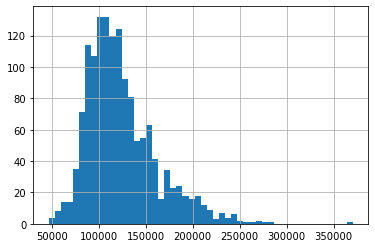

In [33]:
lin_model = joblib.load('linear_regression.joblib') 
pred = lin_model.predict(data)
pd.Series(np.exp(pred)).hist(bins=50)

What shortcomings, inconvenience and problems did you find when scoring new data?

# List of problems

- re-wrote a lot of code ==> repetitive
- hard coded a lot of parameters ==> if these change we need to re-write them again
- engineered a lot of variables that we actually do not need for the model
- additional variables present missing data, we do not know what to do with them

We can minimize these hurdles by using Open-source. And we will see how in the next videos.